In [1]:
# Standard library imports 
import sys
sys.path.append('../')
# thrid party imports
import pandas as pd
import numpy as np
# local imports
from BERT_geoparser.train_model import Trainer
from BERT_geoparser.analysis import Results

# 4. Retraining the TopoBERT model on relationally tagged data
We will now retrain our WikiNeural trained TopoBERT model on the retagged dataset. By specifying `output_csv=...` we will be able to look at the tags applied by the model, and assess how well it performes againsed the human tagged sample. 

In [ ]:
trainer = Trainer(data_path = r'../data/NB3/wiki_places_retagged_train.csv', 
                  model_size = 'large',
                  cased = True, 
                  learning_rate=2e-6,
                  max_len=80,
                  saved_model=False)

trainer.train(save_as='r../models/TopoBERT_relational.hdf5',
              n_epochs=20,
              batch_size=4,
              val_split=0.1) 
              
trainer.test(test_data='../data/NB3/wiki_places_retagged_test.csv',
             results_filename='../results/wiki_places_results.txt',
             output_csv='../data/NB4/wiki_places_results.csv')

## 4.1 Analysing the results against test data
In this section, we will assess how well the model performed against the test set of algorithm applied tags.


In [2]:
results_df = pd.read_csv('../data/NB4/wiki_places_results.csv')

In [3]:
# first we want the number of tags applied by the algorithm and the model
tags = results_df.tag.unique()
N_tagged = {}
N_pred = {}
for tag in tags:
    N_tagged.update({tag:len(results_df[results_df.tag==tag])})
    N_pred.update({tag:len(results_df[results_df.pred==tag])})

In [4]:
# Algorithm applied tags
N_tagged

{'O': 43226,
 'B-TAR': 2852,
 'B-INC': 3074,
 'I-INC': 1431,
 'B-PAR': 4364,
 'I-TAR': 681,
 'I-PAR': 963,
 'B-ADJ': 1336,
 'I-ADJ': 588,
 'B-CRO': 199,
 'I-CRO': 70,
 'B-CHI': 954,
 'I-CHI': 283}

In [5]:
# model predicted tags
N_pred

{'O': 43180,
 'B-TAR': 3116,
 'B-INC': 2391,
 'I-INC': 1176,
 'B-PAR': 4683,
 'I-TAR': 710,
 'I-PAR': 1102,
 'B-ADJ': 1253,
 'I-ADJ': 660,
 'B-CRO': 230,
 'I-CRO': 98,
 'B-CHI': 1109,
 'I-CHI': 313}

## 4.2 Confusion matrices

In [6]:
# We'll now look at the recall of the model (i.e. what did the model predict when the alg predicted X)
recall_hm = {}
tags = ['B-TAR', 'I-TAR', 'B-PAR', 'I-PAR', 'B-CHI', 'I-CHI', 'B-ADJ', 'I-ADJ', 'B-CRO', 'I-CRO', 'B-INC', 'I-INC', 'O']
for tag in tags:    
    tagged = results_df[results_df.tag == tag]
    guesses = {}
    for pred in tags:
        guesses.update({pred: len(tagged[tagged.pred==pred])/len(tagged)})
    recall_hm.update({tag:guesses})
    
recall_hm

{'B-TAR': {'B-TAR': 0.9768583450210379,
  'I-TAR': 0.0,
  'B-PAR': 0.0038569424964936885,
  'I-PAR': 0.0,
  'B-CHI': 0.004207573632538569,
  'I-CHI': 0.0003506311360448808,
  'B-ADJ': 0.0035063113604488078,
  'I-ADJ': 0.0,
  'B-CRO': 0.0,
  'I-CRO': 0.0,
  'B-INC': 0.010869565217391304,
  'I-INC': 0.0003506311360448808,
  'O': 0.0},
 'I-TAR': {'B-TAR': 0.002936857562408223,
  'I-TAR': 0.9676945668135095,
  'B-PAR': 0.0,
  'I-PAR': 0.005873715124816446,
  'B-CHI': 0.0,
  'I-CHI': 0.0,
  'B-ADJ': 0.0,
  'I-ADJ': 0.00881057268722467,
  'B-CRO': 0.0,
  'I-CRO': 0.0,
  'B-INC': 0.0,
  'I-INC': 0.014684287812041116,
  'O': 0.0},
 'B-PAR': {'B-TAR': 0.011457378551787351,
  'I-TAR': 0.0,
  'B-PAR': 0.9560036663611365,
  'I-PAR': 0.0018331805682859762,
  'B-CHI': 0.0,
  'I-CHI': 0.0,
  'B-ADJ': 0.008936755270394134,
  'I-ADJ': 0.001374885426214482,
  'B-CRO': 0.0,
  'I-CRO': 0.0,
  'B-INC': 0.01764436296975252,
  'I-INC': 0.0,
  'O': 0.002749770852428964},
 'I-PAR': {'B-TAR': 0.0031152647975077

In [7]:
# And the inverse of that (what was alg prediction when model was X)
precision_hm = {}

for pred in tags:    
    predicted = results_df[results_df.pred==pred]
    guesses = {}
    for tag in tags:
        guesses.update({tag: len(predicted[predicted.tag==tag])/len(predicted)})
    precision_hm.update({pred:guesses})
    
precision_hm

{'B-TAR': {'B-TAR': 0.8940949935815148,
  'I-TAR': 0.0006418485237483953,
  'B-PAR': 0.016046213093709884,
  'I-PAR': 0.0009627727856225931,
  'B-CHI': 0.00994865211810013,
  'I-CHI': 0.0,
  'B-ADJ': 0.011553273427471117,
  'I-ADJ': 0.0,
  'B-CRO': 0.0019255455712451862,
  'I-CRO': 0.0,
  'B-INC': 0.05808729139922978,
  'I-INC': 0.002246469833119384,
  'O': 0.004492939666238768},
 'I-TAR': {'B-TAR': 0.0,
  'I-TAR': 0.928169014084507,
  'B-PAR': 0.0,
  'I-PAR': 0.018309859154929577,
  'B-CHI': 0.0,
  'I-CHI': 0.008450704225352112,
  'B-ADJ': 0.0014084507042253522,
  'I-ADJ': 0.005633802816901409,
  'B-CRO': 0.0,
  'I-CRO': 0.0,
  'B-INC': 0.0,
  'I-INC': 0.0323943661971831,
  'O': 0.005633802816901409},
 'B-PAR': {'B-TAR': 0.002348921631432842,
  'I-TAR': 0.0,
  'B-PAR': 0.890881913303438,
  'I-PAR': 0.0012812299807815502,
  'B-CHI': 0.002348921631432842,
  'I-CHI': 0.0,
  'B-ADJ': 0.01943198804185351,
  'I-ADJ': 0.0012812299807815502,
  'B-CRO': 0.0,
  'I-CRO': 0.0,
  'B-INC': 0.079863

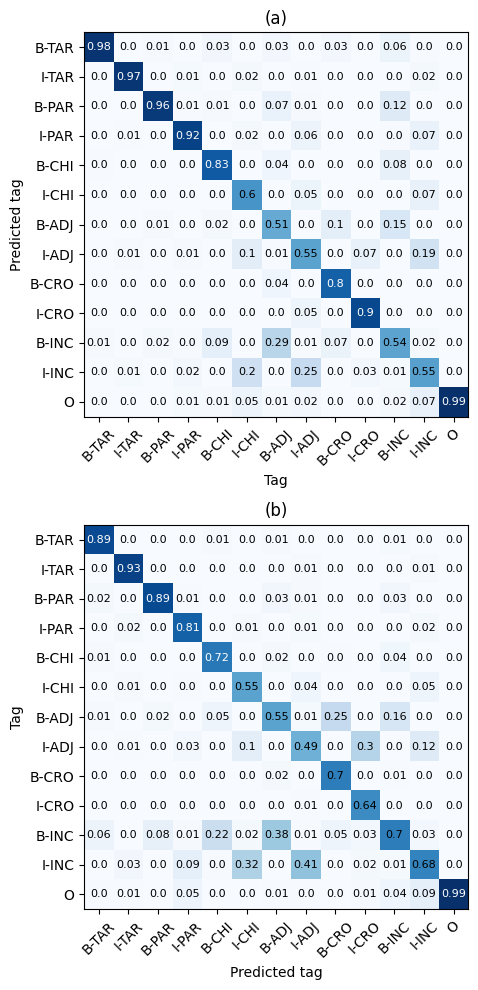

In [8]:
# and we'll plot those
import numpy as np
import matplotlib.pyplot as plt

## recall heat map
heat_map = np.array([list(v.values()) for k,v in recall_hm.items()])
tags = list(recall_hm.keys())

fig, ax = plt.subplots(2, 1, figsize=(5,10))
im = ax[0].imshow(heat_map.T, cmap='Blues')
ax[0].set_xticks(np.arange(len(tags)), labels=tags, rotation=45)
ax[0].set_yticks(np.arange(len(tags)), labels=tags)

ax[0].set_xlabel('Tag')
ax[0].set_ylabel('Predicted tag')
# Loop over data dimensions and create text annotations.
for i, hum_tag in enumerate(tags):
    for j, alg_tag in enumerate(tags):
        if recall_hm[alg_tag][hum_tag] > 0.7:
            text = ax[0].text(j, i, np.round(recall_hm[alg_tag][hum_tag],2),
                        ha="center", va="center", color="w", size=8)
        else:
            text = ax[0].text(j, i, np.round(recall_hm[alg_tag][hum_tag],2),
                        ha="center", va="center", color="k", size=8)

ax[0].set_title("(a)")

## precision heat map
heat_map = np.array([list(v.values()) for k,v in precision_hm.items()])
tags = list(precision_hm.keys())

im = ax[1].imshow(heat_map.T, cmap='Blues')
ax[1].set_xticks(np.arange(len(tags)), labels=tags, rotation=45)
ax[1].set_yticks(np.arange(len(tags)), labels=tags)

ax[1].set_xlabel('Predicted tag')
ax[1].set_ylabel('Tag')
# Loop over data dimensions and create text annotations.
for i, hum_tag in enumerate(tags):
    for j, alg_tag in enumerate(tags):
        if precision_hm[alg_tag][hum_tag] > 0.7:
            text = ax[1].text(j, i, np.round(precision_hm[alg_tag][hum_tag],2),
                        ha="center", va="center", color="w", size=8)
        else:
            text = ax[1].text(j, i, np.round(precision_hm[alg_tag][hum_tag],2),
                        ha="center", va="center", color="k", size=8)
ax[1].set_title("(b)")
ax[1].grid(which="minor", color='g')
ax[1].tick_params(which="minor", bottom=False, left=False)

fig.tight_layout()
plt.show()   

#fig.savefig('../results/fig_2.pdf')

## 4.3 Precision, Recall and F1
We'll use the `results` class in `analsyis.py` to calculate some of the accuracy metrics.

In [ ]:
# get the F1 score, precision and recall
category_accuracy = {}

for tag in ['TAR', 'PAR', 'CHI', 'ADJ', 'CRO', 'INC']:
    
    assigned = results_df[results_df.Tag.str.contains(tag)]
    not_assigned = reviewed_data[~reviewed_data.Tag.str.contains(tag)]
    reviewed = reviewed_data[reviewed_data.human_tag==human_tag]
    
    TP = len(assigned[assigned.correct=='y'])
    FP = len(assigned[assigned.correct=='n'])
    FN = len(not_assigned[not_assigned.human_tag==human_tag])
    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    
    F1 = 2*(precision*recall)/(precision+recall)
    
    
    results = {'total':len(reviewed),
               'assigned':len(assigned),
               'precision':precision,
               'recall':recall,
               'F1':F1}
    #recall = 
    category_accuracy.update({tag:results})

for tag, res in category_accuracy.items():
    print(tag)
    print(f'Total assigned by human : {res["total"]}')
    print(f'Total assigned by algorithm : {res["assigned"]}')
    print(f'Precision : {np.round(res["precision"], 3)}')
    print(f'Recall : {np.round(res["recall"], 3)}')
    print(f'F1 : {np.round(res["F1"], 3)}')
    print('###############################')

In [9]:
results = Results(results_df)
category_accuracy = {}

for tag in tags:    
    category_accuracy.update({tag:results.build_accuracy_dict(tag)})

for tag, res in category_accuracy.items():
    print(tag)
    print(f'Total assigned by human : {res["total tagged"]}')
    print(f'Total assigned by algorithm : {res["total predicted"]}')
    print(f'Precision : {np.round(res["precision"], 3)}')
    print(f'Recall : {np.round(res["recall"], 3)}')
    print(f'F1 : {np.round(res["F1"], 3)}')
    print('###################################')

B-TAR
Total assigned by human : 2852
Total assigned by algorithm : 3116
Precision : 0.894
Recall : 0.977
F1 : 0.934
###################################
I-TAR
Total assigned by human : 681
Total assigned by algorithm : 710
Precision : 0.928
Recall : 0.968
F1 : 0.948
###################################
B-PAR
Total assigned by human : 4364
Total assigned by algorithm : 4683
Precision : 0.891
Recall : 0.956
F1 : 0.922
###################################
I-PAR
Total assigned by human : 963
Total assigned by algorithm : 1102
Precision : 0.807
Recall : 0.923
F1 : 0.861
###################################
B-CHI
Total assigned by human : 954
Total assigned by algorithm : 1109
Precision : 0.716
Recall : 0.832
F1 : 0.77
###################################
I-CHI
Total assigned by human : 283
Total assigned by algorithm : 313
Precision : 0.546
Recall : 0.604
F1 : 0.574
###################################
B-ADJ
Total assigned by human : 1336
Total assigned by algorithm : 1253
Precision : 0.546
Recal

In [10]:
micro_f1 = results.micro_average_F1(tags)
macro_recall = results.macro_average(tags, 'recall')
macro_precision = results.macro_average(tags, 'precision')
macro_F1 = results.macro_average(tags, 'F1')

print(f'Micro average F1 : {micro_f1}')
print(f'Macro average precision : {macro_precision}')
print(f'Macro average recall : {macro_recall}')
print(f'Macro average F1 : {macro_F1}')

Micro average F1 : 0.9345395778144315
Macro average precision : 0.7323022749863008
Macro average recall : 0.7779077635029986
Macro average F1 : 0.7507732604124258


## 4.4 Assessing the model performance against the human reviewed data.

In [11]:
reviewed_data = pd.read_csv('../data/NB3/wiki_places_reviewed.csv')
test_results = pd.read_csv('../data/NB4/wiki_places_results.csv')
test_data = pd.read_csv('../data/NB3/wiki_places_retagged_test.csv')

#update the sentence numbers to reflect the sentence numbers used in the test data
sentence_numbers = sorted(test_data['Sentence #'].unique())
new_column = []
sentence_index = 0
for i, row in test_results.iterrows():
    new_column.append(sentence_numbers[row.sentence_number])

test_results['sentence_number'] = new_column
    

In [12]:
# cut the test results down to just those that have been reviewed.
reviewed_results = test_results[test_results.sentence_number.isin(reviewed_data['Sentence #'].unique())]
reviewed_results = reviewed_results.reset_index()
reviewed_results['human_tag'] = reviewed_data['human_tag']
reviewed_results = reviewed_results.rename(columns={'pred':'model_tag'})
reviewed_results.head()

,index,sentence_number,token,tag,model_tag,B-ADJ,B-CHI,B-CRO,B-INC,B-PAR,B-TAR,I-ADJ,I-CHI,I-CRO,I-INC,I-PAR,I-TAR,O,PAD,human_tag
0,235,54,[CLS],O,O,1.286002e-04,5.767022e-06,2.873936e-05,0.000135,2.964612e-05,1.408674e-05,6.158658e-05,2.827483e-05,2.234723e-05,4.649482e-05,6.273906e-05,3.330579e-05,0.999403,6.775577e-07,O
1,236,54,it,O,O,5.215906e-07,2.311702e-08,2.239704e-07,0.000002,9.140326e-08,8.636638e-08,4.426547e-07,4.410185e-07,1.078529e-07,4.450441e-07,8.641305e-07,4.462418e-07,0.999994,4.820100e-10,O
2,237,54,is,O,O,3.830527e-07,1.730437e-08,1.542268e-07,0.000001,5.903552e-08,5.935300e-08,3.563942e-07,3.152276e-07,8.680481e-08,2.879743e-07,7.233344e-07,2.895852e-07,0.999996,3.212434e-10,O
3,238,54,included,O,O,3.763115e-07,1.516030e-08,1.419698e-07,0.000001,6.269083e-08,5.270073e-08,3.382986e-07,2.790119e-07,8.465293e-08,2.792174e-07,6.211657e-07,2.455733e-07,0.999996,3.002703e-10,O
4,239,54,in,O,O,3.704345e-07,1.100030e-08,1.251120e-07,0.000001,5.882268e-08,4.217690e-08,2.717385e-07,1.959360e-07,6.590366e-08,2.395019e-07,4.501191e-07,2.069264e-07,0.999997,2.430398e-10,O


In [13]:
# need to convert the tags from e.g. 'B-PAR' to 'P'
human_tag_dict = {'TAR':'T', 'PAR':'P', 'CHI':'C', 'ADJ':'A', 'CRO':'X', 'INC':'I', 'O':'O'}
converted_tags = []
for i, row in reviewed_results.iterrows():
    m_tag = row.model_tag
    if m_tag == 'O':
        new_tag = 'O'
    else:
        new_tag = human_tag_dict[m_tag[2:]]
    converted_tags.append(new_tag)
 # add 'pred' and 'tag' columns, as required by Results class   
reviewed_data['tag'] = reviewed_data['human_tag']
reviewed_data['pred'] = converted_tags
# change human assigned 'N' tags to 'I' as unused by model
reviewed_data['tag'] = reviewed_data['tag'].replace({'N':'I'})

tags = human_tag_dict.values()

In [33]:
results = Results(reviewed_data)
# build the accuracy stats dict
category_accuracy = {}
for tag in tags:    
    category_accuracy.update({tag:results.build_accuracy_dict(tag)})

for tag, res in category_accuracy.items():
    print(tag)
    print(f'Total assigned by human : {res["total tagged"]}')
    print(f'Total assigned by algorithm : {res["total predicted"]}')
    print(f'Precision : {np.round(res["precision"], 3)}')
    print(f'Recall : {np.round(res["recall"], 3)}')
    print(f'F1 : {np.round(res["F1"], 3)}')
    print('###################################')

T
Total assigned by human : 796
Total assigned by algorithm : 849
Precision : 0.887
Recall : 0.946
F1 : 0.916
###################################
P
Total assigned by human : 1472
Total assigned by algorithm : 1294
Precision : 0.944
Recall : 0.83
F1 : 0.884
###################################
C
Total assigned by human : 350
Total assigned by algorithm : 260
Precision : 0.931
Recall : 0.691
F1 : 0.793
###################################
A
Total assigned by human : 380
Total assigned by algorithm : 364
Precision : 0.56
Recall : 0.537
F1 : 0.548
###################################
X
Total assigned by human : 50
Total assigned by algorithm : 58
Precision : 0.655
Recall : 0.76
F1 : 0.704
###################################
I
Total assigned by human : 498
Total assigned by algorithm : 756
Precision : 0.443
Recall : 0.673
F1 : 0.534
###################################


In [19]:
# get the confusion matrices
category_recall = {}

# loop over human tags
for h_tag in ['T', 'P', 'C', 'A', 'X', 'I']:
    # get all data tagged by human as that tag
    human_tagged = reviewed_data[reviewed_data.tag==h_tag]
    guesses = {}
    # loop over model tags
    for tag in ['T', 'P', 'C', 'A', 'X', 'I']:
        model_tagged = len(human_tagged[human_tagged.pred == tag])
        guesses.update({tag: model_tagged/len(human_tagged)})
    category_recall.update({h_tag:guesses})
    
category_recall

{'T': {'T': 0.9459798994974874,
  'P': 0.0037688442211055275,
  'C': 0.007537688442211055,
  'A': 0.010050251256281407,
  'X': 0.0,
  'I': 0.02512562814070352},
 'P': {'T': 0.01154891304347826,
  'P': 0.8301630434782609,
  'C': 0.0,
  'A': 0.03125,
  'X': 0.0,
  'I': 0.11413043478260869},
 'C': {'T': 0.09142857142857143,
  'P': 0.0,
  'C': 0.6914285714285714,
  'A': 0.05142857142857143,
  'X': 0.0,
  'I': 0.16285714285714287},
 'A': {'T': 0.018421052631578946,
  'P': 0.031578947368421054,
  'C': 0.002631578947368421,
  'A': 0.5368421052631579,
  'X': 0.05263157894736842,
  'I': 0.3473684210526316},
 'X': {'T': 0.0, 'P': 0.0, 'C': 0.0, 'A': 0.24, 'X': 0.76, 'I': 0.0},
 'I': {'T': 0.060240963855421686,
  'P': 0.07228915662650602,
  'C': 0.02208835341365462,
  'A': 0.142570281124498,
  'X': 0.0,
  'I': 0.6726907630522089}}

In [20]:
# get the confusion matrices
category_precision = {}

# loop over human tags
for h_tag in ['T', 'P', 'C', 'A', 'X', 'I']:
    # get all data tagged by human as that tag
    human_tagged = reviewed_data[reviewed_data.pred==h_tag]
    guesses = {}
    # loop over model tags
    for tag in ['T', 'P', 'C', 'A', 'X', 'I']:
        model_tagged = len(human_tagged[human_tagged.tag == tag])
        guesses.update({tag: model_tagged/len(human_tagged)})
    category_precision.update({h_tag:guesses})
    
category_precision

{'T': {'T': 0.8869257950530035,
  'P': 0.020023557126030624,
  'C': 0.03769140164899882,
  'A': 0.008244994110718492,
  'X': 0.0,
  'I': 0.0353356890459364},
 'P': {'T': 0.00231839258114374,
  'P': 0.9443585780525502,
  'C': 0.0,
  'A': 0.00927357032457496,
  'X': 0.0,
  'I': 0.027820710973724884},
 'C': {'T': 0.023076923076923078,
  'P': 0.0,
  'C': 0.9307692307692308,
  'A': 0.0038461538461538464,
  'X': 0.0,
  'I': 0.04230769230769231},
 'A': {'T': 0.02197802197802198,
  'P': 0.12637362637362637,
  'C': 0.04945054945054945,
  'A': 0.5604395604395604,
  'X': 0.03296703296703297,
  'I': 0.19505494505494506},
 'X': {'T': 0.0,
  'P': 0.0,
  'C': 0.0,
  'A': 0.3448275862068966,
  'X': 0.6551724137931034,
  'I': 0.0},
 'I': {'T': 0.026455026455026454,
  'P': 0.2222222222222222,
  'C': 0.07539682539682539,
  'A': 0.1746031746031746,
  'X': 0.0,
  'I': 0.44312169312169314}}

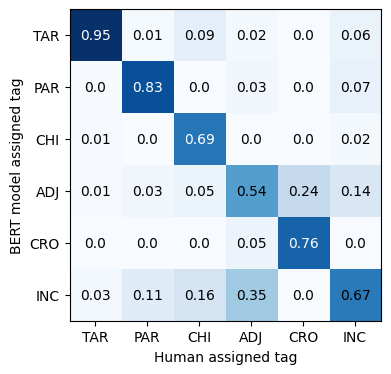

In [21]:
# Plot the confusion matrices
heat_map = np.array([list(v.values()) for k,v in category_recall.items()])
rev_tag_dict = {v:k for k,v in human_tag_dict.items()}
tags = list(category_recall.keys())

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(heat_map.T, cmap='Blues')

full_tags = [rev_tag_dict[t] for t in tags]
ax.set_xticks(np.arange(len(tags)), labels=['TAR', 'PAR', 'CHI', 'ADJ', 'CRO', 'INC'])
ax.set_yticks(np.arange(len(tags)), labels=['TAR', 'PAR', 'CHI', 'ADJ', 'CRO', 'INC'])

ax.set_xlabel('Human assigned tag')
ax.set_ylabel('BERT model assigned tag')
# Loop over data dimensions and create text annotations.
for i, hum_tag in enumerate(tags):
    for j, alg_tag in enumerate(tags):
        val = category_recall[alg_tag][hum_tag]
        if val > 0.69:
            color = 'w'
        else:
            color = 'k'
        text = ax.text(j, i, np.round(val,2),
                       ha="center", va="center", color=color)

#ax.set_title("Proportion of algorithm assigned tags matching a given human assigned tag")
fig.tight_layout()
plt.show() 
fig.savefig('../results/fig_3.pdf')

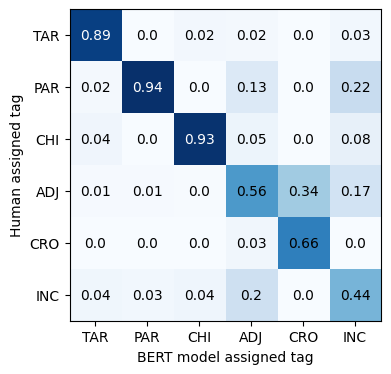

In [35]:
# Plot the confusion matrices
heat_map = np.array([list(v.values()) for k,v in category_precision.items()])
rev_tag_dict = {v:k for k,v in human_tag_dict.items()}
tags = list(category_precision.keys())

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(heat_map.T, cmap='Blues')

full_tags = [rev_tag_dict[t] for t in tags]
ax.set_xticks(np.arange(len(tags)), labels=['TAR', 'PAR', 'CHI', 'ADJ', 'CRO', 'INC'])
ax.set_yticks(np.arange(len(tags)), labels=['TAR', 'PAR', 'CHI', 'ADJ', 'CRO', 'INC'])

ax.set_ylabel('Human assigned tag')
ax.set_xlabel('BERT model assigned tag')
# Loop over data dimensions and create text annotations.
for i, hum_tag in enumerate(tags):
    for j, alg_tag in enumerate(tags):
        val = category_precision[alg_tag][hum_tag]
        if val > 0.69:
            color = 'w'
        else:
            color = 'k'
        text = ax.text(j, i, np.round(val,2),
                       ha="center", va="center", color=color)

#ax.set_title("Proportion of algorithm assigned tags matching a given human assigned tag")
fig.tight_layout()
plt.show() 
#fig.savefig('fig_3.pdf')